# 🏞 Convolutional Neural Network


In this notebook, we'll walk through the steps required to train your own convolutional neural network (CNN) on the CIFAR dataset


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from rich.progress import Progress

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import v2

from notebooks.utils import display

## 0. Parameters


In [2]:
NUM_CLASSES = 10
BATCH_SIZE = 32
EPOCHS = 10

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    gpu_name = torch.cuda.get_device_name(0)
    print(f"Let's use CUDA ({gpu_name})")
else:
    device = torch.device('cpu')

Let's use CUDA (NVIDIA RTX 6000 Ada Generation)


## 1. Prepare the Data


In [4]:
transforms = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
train_set = datasets.CIFAR10(root='data', train=True, download=True, transform=transforms)
test_set = datasets.CIFAR10(root='data', train=False, download=True, transform=transforms)

100%|██████████| 170498071/170498071 [00:13<00:00, 12789612.17it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [5]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

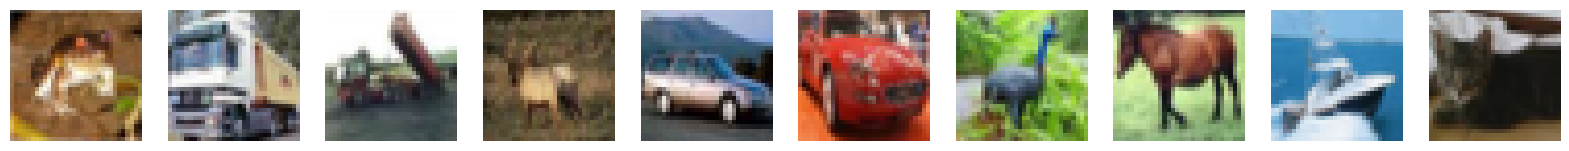

[6 9 9 4 1 1 2 7 8 3]


In [6]:
x_train = np.array([train_set[i][0] for i in range(10)])
y_train = np.array([train_set[i][1] for i in range(10)])
display(x_train)
print(y_train)

## 2. Build the model


In [24]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(4096, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):
        return self.net(x)

## 3. Train the model


In [25]:
model = CNN()
model.to(device)

opt = torch.optim.Adam(model.parameters(), lr=0.0005)

In [26]:
with Progress() as progress:
    ema_loss = 0.0
    ema_acc = 0.0
    for epoch in range(EPOCHS):
        train_task = progress.add_task('Training...', total=len(train_loader))
        model.train()
        for batch in train_loader:
            X, y = batch
            X = X.to(device)
            y = y.to(device)
            log_y_pred = model(X)
            loss = F.nll_loss(log_y_pred, y)
            acc = (log_y_pred.argmax(dim=1) == y).float().mean()

            opt.zero_grad()
            loss.backward()
            opt.step()

            ema_loss = 0.9 * ema_loss + 0.1 * loss.item()
            ema_acc = 0.9 * ema_acc + 0.1 * acc.item()
            progress.update(
                train_task,
                advance=1,
                description=f'[{epoch + 1}/{EPOCHS}] loss: {ema_loss:.4f}, accuracy: {ema_acc:.4f}',
            )

        progress.update(train_task, refresh=True)

Output()

## 4. Evaluation


In [27]:
avg_loss = 0.0
avg_acc = 0.0
count = 0
preds = []

with Progress() as progress:
    test_task = progress.add_task('Testing...', total=len(test_loader))
    model.eval()
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)
        with torch.no_grad():
            log_y_pred = model(X)
            loss = F.nll_loss(log_y_pred, y)
            acc = (log_y_pred.argmax(dim=-1) == y).float().mean()

        avg_loss += loss.item() * X.size(0)
        avg_acc += acc.item() * X.size(0)
        count += X.size(0)
        preds.append(log_y_pred.detach().cpu().numpy())

        progress.update(test_task, advance=1)

    progress.update(test_task, refresh=True)

    avg_loss /= count
    avg_acc /= count
    preds = np.concatenate(preds, axis=0)

    progress.console.log(f'[Test] loss: {avg_loss:.4f}, accuracy: {avg_acc:.4f}')

Output()

[06:52:16] [Test] loss: 0.7136, accuracy: 0.7634                                                   ]8;id=362177;file:///tmp/ipykernel_151442/1122861311.py\1122861311.py]8;;\:]8;id=929028;file:///tmp/ipykernel_151442/1122861311.py#30\30]8;;\

In [28]:
CLASSES = np.array(
    [
        'airplane',
        'automobile',
        'bird',
        'cat',
        'deer',
        'dog',
        'frog',
        'horse',
        'ship',
        'truck',
    ]
)

preds_single = CLASSES[np.argmax(preds, axis=-1)]
actual_single = CLASSES[test_set.targets]

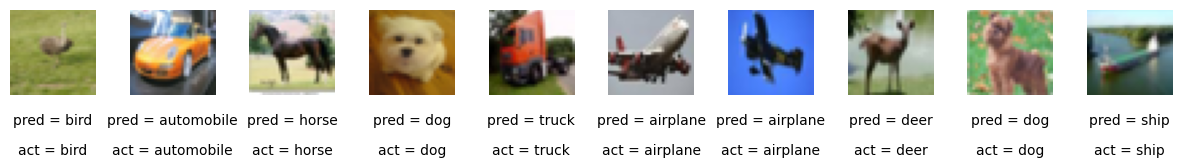

In [29]:
n_to_show = 10
indices = np.random.choice(range(len(test_set)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = test_set.data[idx]
    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        "pred = " + str(preds_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        -0.7,
        "act = " + str(actual_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(img)

plt.show()